In [1]:
import time 
import pandas as pd
import pyreadstat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import EfficientSU2, ExcitationPreserving
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.primitives import StatevectorSampler as Sampler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold
from itertools import product
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


import numpy as np


start_time = time.time()
print("Reading in data.")
df, meta = pyreadstat.read_sav("romantic_love_survey_data.sav")

df_narrowed = df.iloc[:,  24:-1].dropna()
X = df_narrowed.drop("Satisfaction_1", axis=1)
y = df_narrowed['Satisfaction_1']
y = ((y > 3).astype(int)).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaled_data = scaler.fit(X_train)

X_trains = scaler.transform(X_train)
X_tests = scaler.transform(X_test)
print("Dimensionality Reduction.")
pca = PCA(n_components=8)
pca_fitted = pca.fit(X_trains)

X_trains_components = pca.transform(X_trains)
X_tests_components = pca.transform(X_tests)

num_features = X_trains_components.shape[1]
print("Starting quantum stuff: RealAmplitudes")
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

Reading in data.
Dimensionality Reduction.
Starting quantum stuff: RealAmplitudes


In [2]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

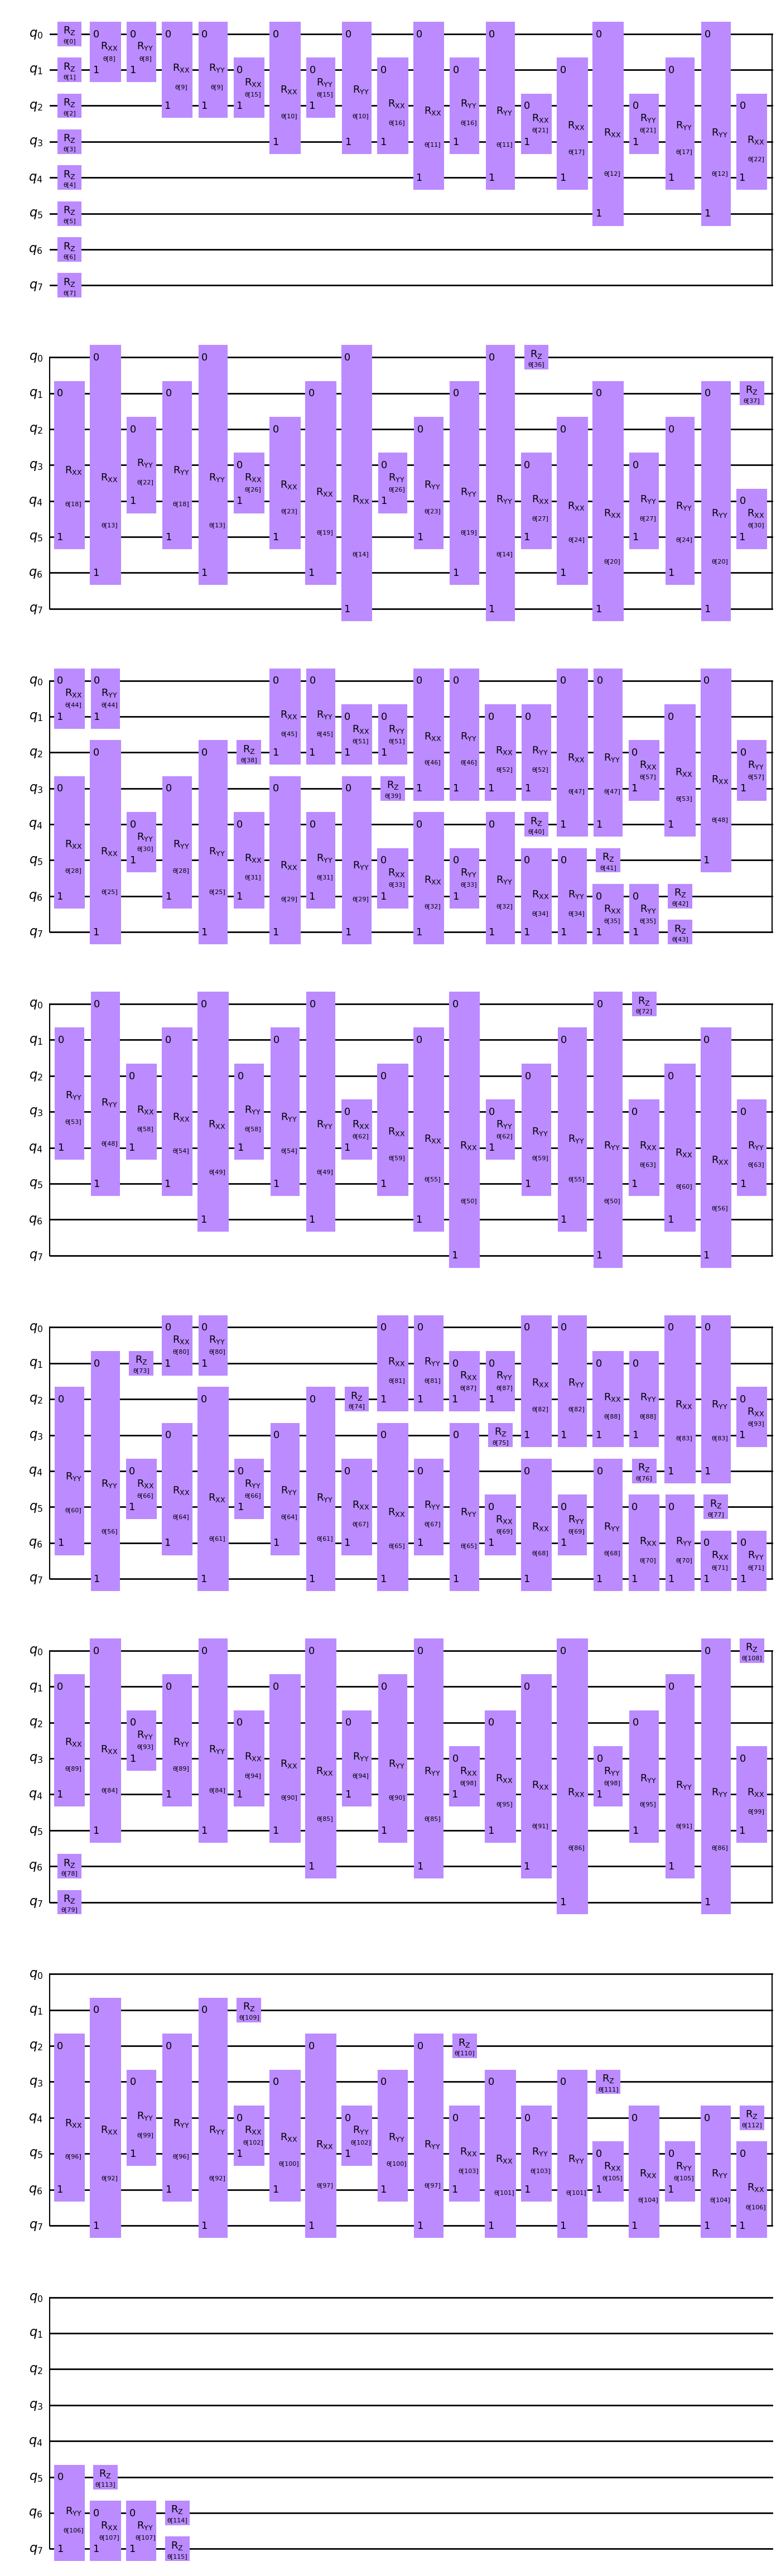

In [4]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
ansatz = ExcitationPreserving(num_qubits=num_features, reps=3)
sampler = Sampler()
optimizer=COBYLA(maxiter=40)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)


In [5]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


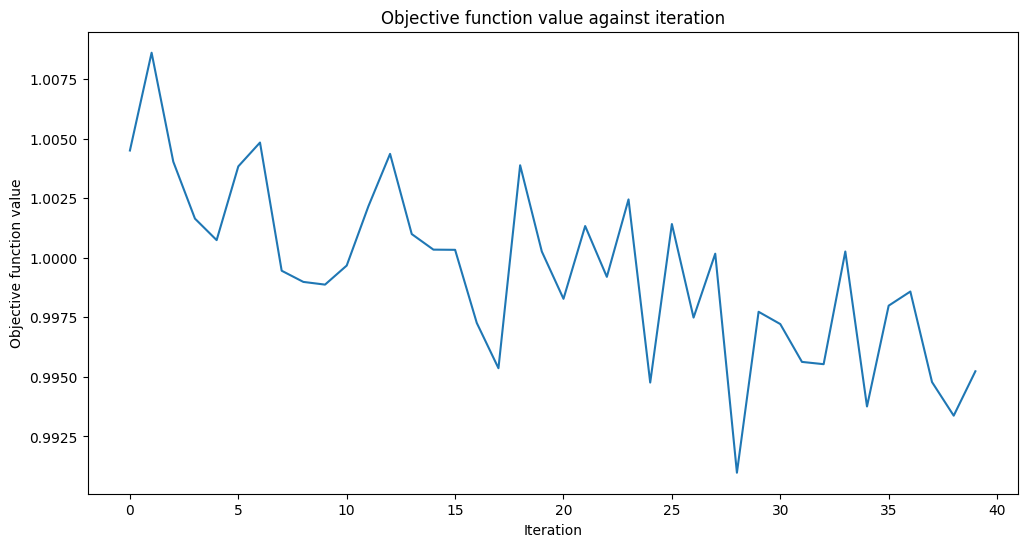

Training time: 1373 seconds


In [6]:
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_trains_components, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")